## Набор данных о тарифах Uber

### Описание:

Проект посвящён крупнейшей в мире компании по предоставлению услуг такси Uber Inc. В рамках этого проекта мы пытаемся спрогнозировать стоимость проезда в будущих транзакциях. Uber ежедневно предоставляет услуги миллионам клиентов. Теперь очень важно правильно управлять их данными, чтобы придумывать новые бизнес-идеи и добиваться наилучших результатов. В конечном счёте, очень важно точно оценивать стоимость проезда.

### Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## 1. Обзор данных

### Загрузка данных

In [9]:
df = pd.read_csv('uber.csv')

In [11]:
# Просматриваем наш файл 

In [13]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


## Описание данных

### Набор данных содержит следующие поля:

- key – уникальный идентификатор для каждой поездки
- pickup_datetime – дата и время, когда счетчик был включен
- passenger_count – количество пассажиров в автомобиле (введено водителем)
- pickup_longitude – долгота , на которой был задействован счетчик
- pickup_latitude – широта, на которой был задействован счетчик
- dropoff_longitude – долгота, на которой счетчик был отключен
- dropoff_latitude – широта, на которой счетчик был отключен

Целевой (искомый) признак:
- fare_amount – стоимость каждой поездки в долларах США

In [19]:
# Количество данных 
df.shape

(200000, 9)

### 2. Предобработка данных

In [22]:
# информация о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Здесь есть несколько аномалий: dropoff_longitude и dropoff_latitude (имеются пропуски).

In [25]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


Здесь обнаружено множество аномалий:

1. fare_amount - имеет отрицательную цену за поездку, а так же максимальная цена имеет 499$ (сравнительно очень дорогая поездка)
2. pickup_longitude - долгота должна быть в диапазоне от -180 до 180, соотвественно имеет аномальные значения
3. pickup_latitude -  широта должна быть в диапазоне от -90 до 90, соотвественно имеет аномальные значения
4. dropoff_longitude - долгота должна быть в диапазоне от -180 до 180, соотвественно имеет аномальные значения
5. dropoff_latitude - широта должна быть в диапазоне от -90 до 90, соотвественно имеет аномальные значения
6. passenger_count - минимальное значение равняется 0 (0 пассажиров в поездке быть не может), а так же максимальное 208 (в машину столько не поместится)

In [28]:
for col in df.columns:
    print('Кол-во пропусков в колонке %s = %d' % (col, df[col].isna().sum()))

Кол-во пропусков в колонке Unnamed: 0 = 0
Кол-во пропусков в колонке key = 0
Кол-во пропусков в колонке fare_amount = 0
Кол-во пропусков в колонке pickup_datetime = 0
Кол-во пропусков в колонке pickup_longitude = 0
Кол-во пропусков в колонке pickup_latitude = 0
Кол-во пропусков в колонке dropoff_longitude = 1
Кол-во пропусков в колонке dropoff_latitude = 1
Кол-во пропусков в колонке passenger_count = 0


### Добавляем медианное значение чтобы было ровно 200 тысяч значений

In [15]:
# Добавляем одно пропущенное значение в колонки dropoff_longitude и dropoff_latitude
df.loc[100000, 'dropoff_longitude'] = np.nan
df.loc[100000, 'dropoff_latitude'] = np.nan

In [17]:
# Вычисляем медиану для колонок dropoff_longitude и dropoff_latitude 
median_dropoff_longitude = df['dropoff_longitude'].median()
median_dropoff_latitude = df['dropoff_latitude'].median()

In [19]:
# Заменяем пропущенные значения на медиану
df['dropoff_longitude'] = df['dropoff_longitude'].fillna(median_dropoff_longitude)
df['dropoff_latitude'] = df['dropoff_latitude'].fillna(median_dropoff_latitude)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  200000 non-null  float64
 7   dropoff_latitude   200000 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


### Убираем аномальные отрицательные и положительные значения

In [40]:
df[(df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180)]['pickup_longitude']

4949      -748.016667
48506     -735.200000
75851    -1340.648410
103745    -736.216667
144253    -768.550000
161652    -735.433332
199936    -736.400000
Name: pickup_longitude, dtype: float64

In [42]:
df[(df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180)]['dropoff_longitude']

32549    -737.916665
75851   -3356.666300
91422    1153.572603
Name: dropoff_longitude, dtype: float64

In [44]:
df[(df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90)]['pickup_latitude']

56617     404.433332
61793     401.066667
75851    1644.421482
91422    1292.016128
Name: pickup_latitude, dtype: float64

In [46]:
df[(df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)]['dropoff_latitude']

75851     872.697628
91422    -881.985513
139447    493.533332
Name: dropoff_latitude, dtype: float64

In [21]:
# Аномальные значений очень малок количество по сравнению с самим датасетом, поэтому их монжо удлаить
for col in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[col] >= -180) & (df[col] <= 180)]
for col in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[col] >= -90) & (df[col] <= 90)]

In [23]:
len(df[(df['passenger_count'] <= 0)])
# Минимальное аномально-минимальное количество человек можно будет удалить, т.к количество сравнительно небольшое 

709

In [25]:
len(df[df['passenger_count'] >= 4])
# А здесь надо заменить на медианное значение

22555

In [27]:
len(df[df['fare_amount'] <= 0])
# Минимальное аномально-минимальное количество человек можно будет удалить, т.к количество сравнительно не большое 

22

In [29]:
len(df[df['fare_amount'] >= 25])
# А здесь надо заменить на медианное значение

14357

In [31]:
# Удалим аномально-минимальное значение пассажиров
df = df[df['passenger_count'] > 0]

In [33]:
# Удалим аномально-минимальное значение цены
df = df[df['fare_amount'] > 0]

In [35]:
df.loc[df['passenger_count'] >= 4, 'passenger_count'] = df['passenger_count'].median()

In [37]:
df.loc[df['fare_amount'] >= 25, 'fare_amount'] = df['fare_amount'].median()

### Добавляем номарльную дату

In [40]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [41]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour

In [42]:
df.drop(['pickup_datetime'], axis=1, inplace=True)

### Убираем ключ и шифр, они нам не пригодятся

In [47]:
df.drop(['key'], axis=1, inplace=True)

In [49]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Добавляем нормальное расстояние

In [52]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [54]:
from geopy.distance import geodesic 
df['distance'] = [round(geodesic((df.pickup_latitude[i], df.pickup_longitude[i]),
                                 (df.dropoff_latitude[i], df.dropoff_longitude[i])).km, 2) for i in df.index]

In [55]:
df.head(3)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,1.68
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,2.45
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,5.04


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199257 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199257 non-null  float64
 1   pickup_longitude   199257 non-null  float64
 2   pickup_latitude    199257 non-null  float64
 3   dropoff_longitude  199257 non-null  float64
 4   dropoff_latitude   199257 non-null  float64
 5   passenger_count    199257 non-null  int64  
 6   year               199257 non-null  int32  
 7   month              199257 non-null  int32  
 8   day                199257 non-null  int32  
 9   hour               199257 non-null  int32  
 10  distance           199257 non-null  float64
dtypes: float64(6), int32(4), int64(1)
memory usage: 19.2 MB


In [87]:
df.head(3)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,1.68
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,2.45
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,5.04


### Удаляем дубликаты, если есть

In [59]:
df.duplicated().sum()
# Дубликатов не обнаружено

5

In [61]:
df.drop_duplicates(inplace=True)

### 2. Визуальный анализ

<Figure size 800x600 with 0 Axes>

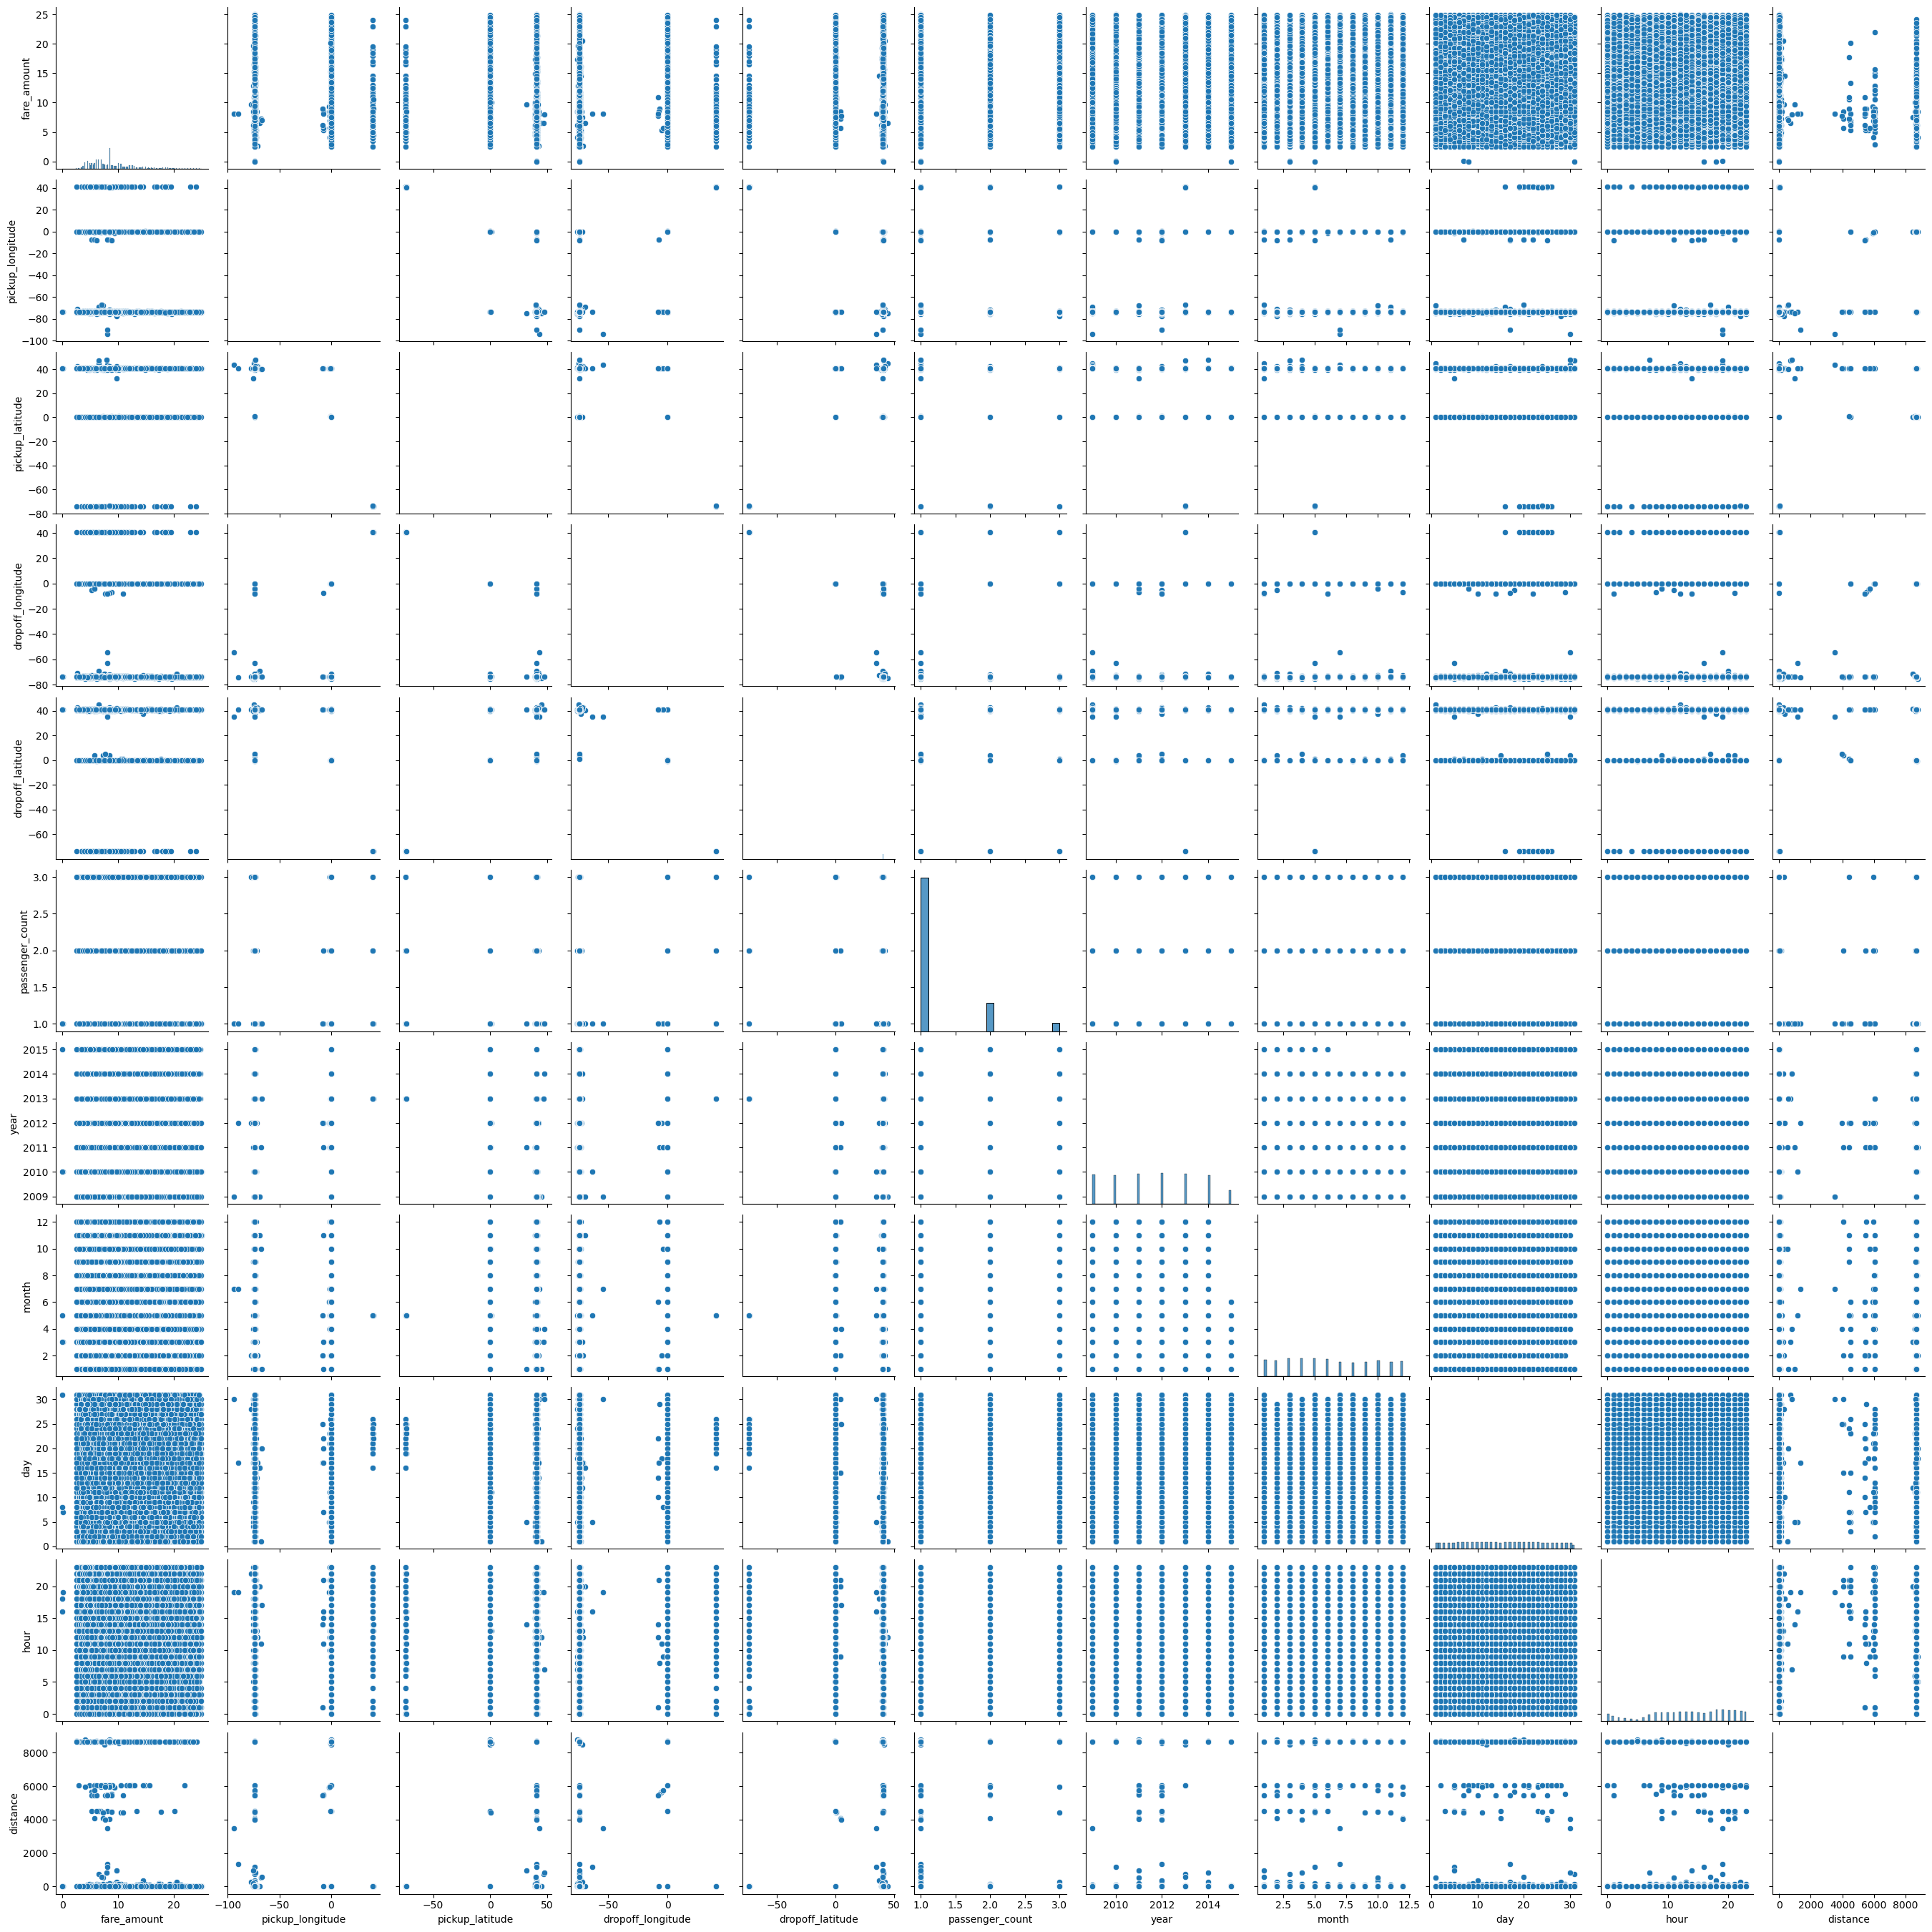

In [98]:
plt.figure(figsize=(8,6))
sns.pairplot(df)

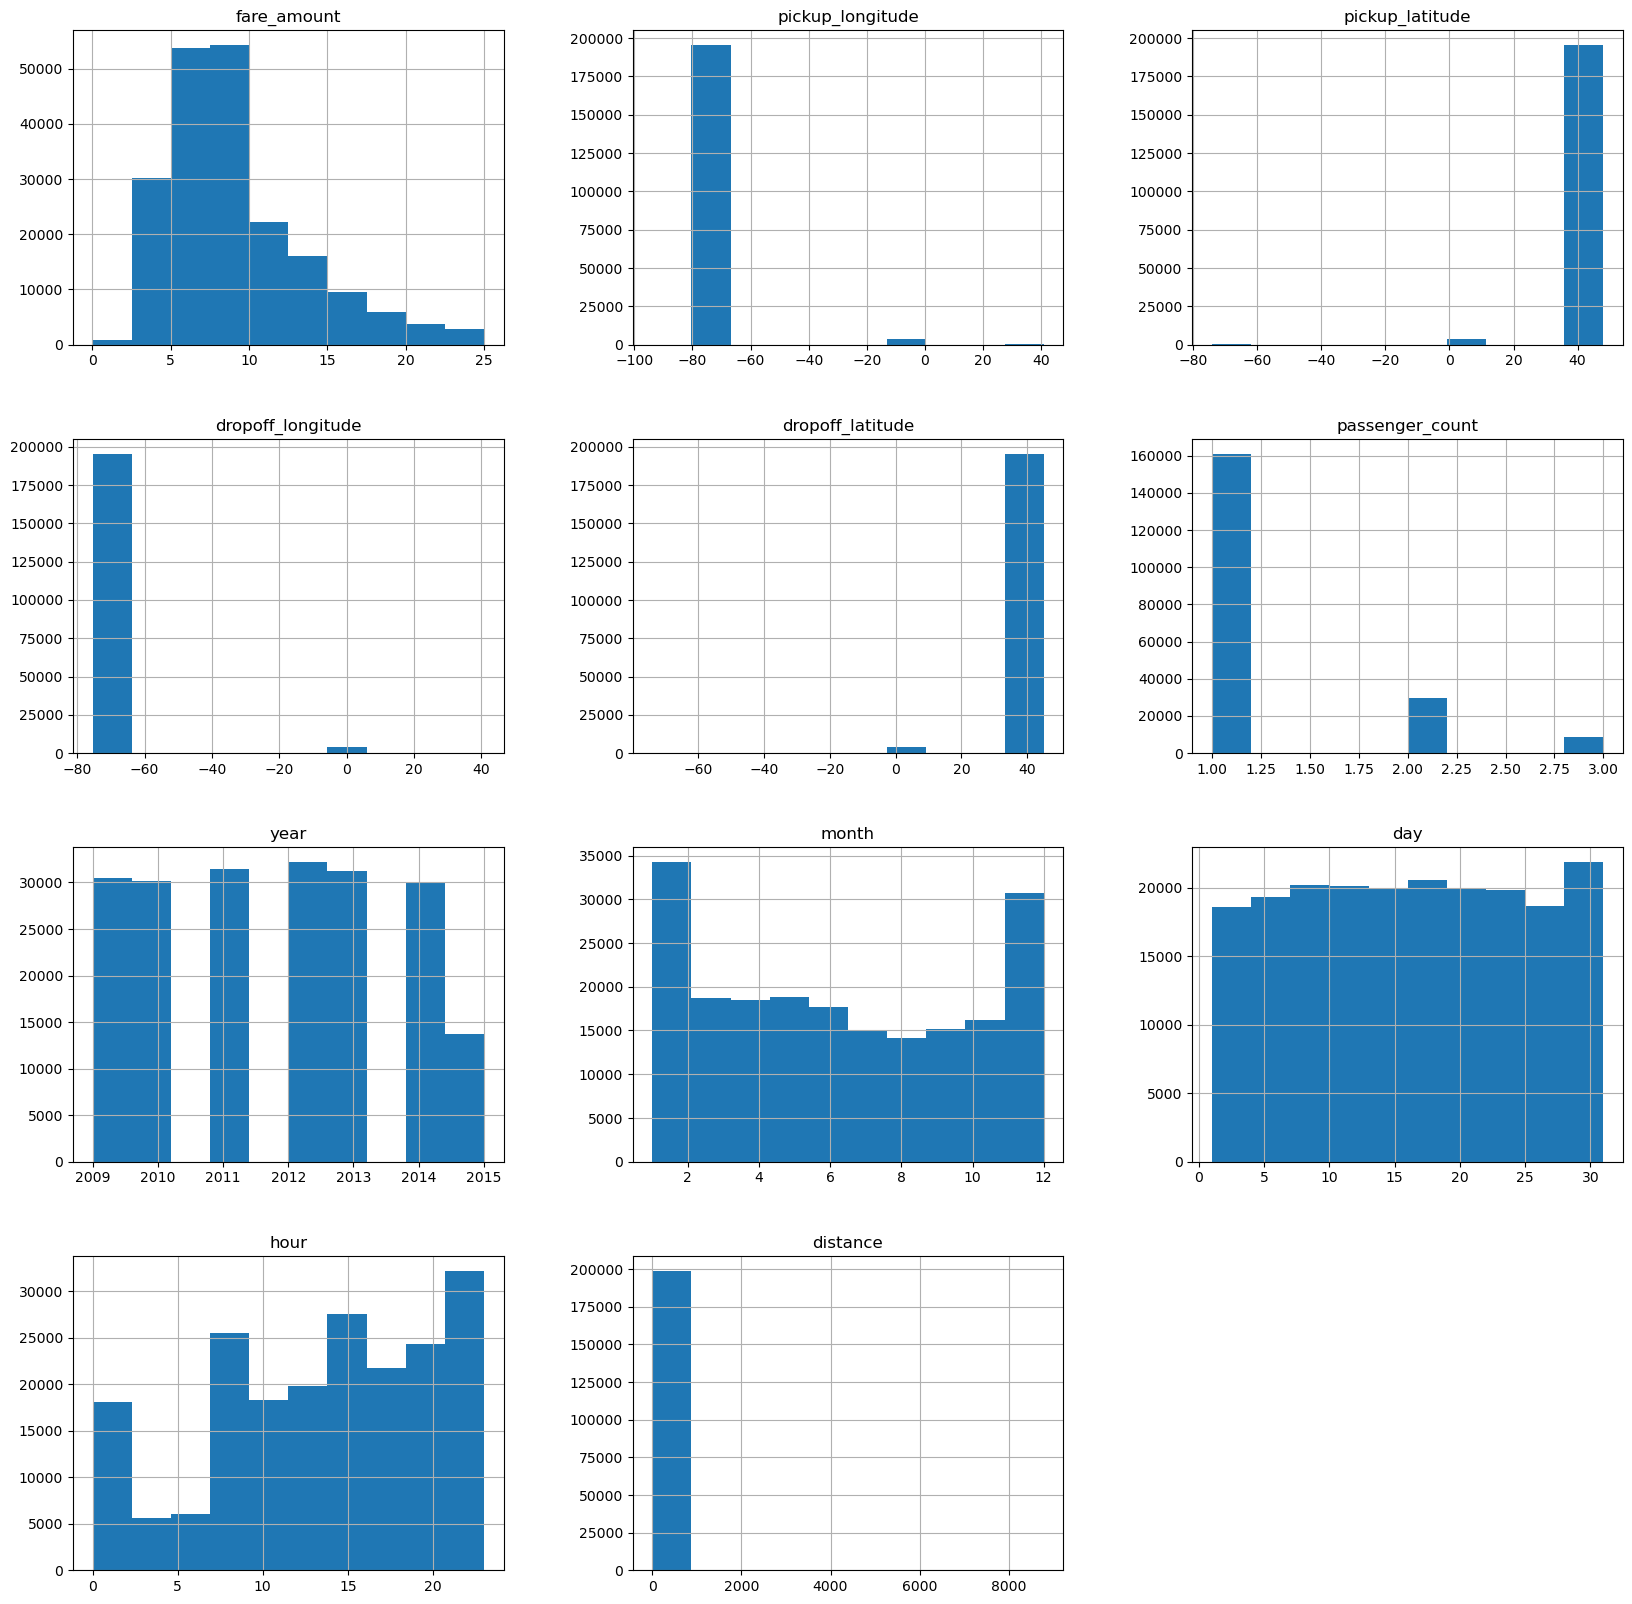

In [96]:
df.hist(figsize=(20,20));

In [101]:
corr = df[['fare_amount','year','month','day','hour','passenger_count', "distance", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "distance"]].corr()
corr

,fare_amount,year,month,day,hour,passenger_count,distance,pickup_longitude,pickup_latitude,dropoff_longitude,distance
fare_amount,1.000000,0.126799,0.026574,0.006555,-0.016585,0.011807,0.001717,-0.000043,-0.000436,-0.001005,0.001717
year,0.126799,1.000000,-0.115527,-0.012099,0.002168,-0.021927,0.026809,0.009666,-0.011974,0.010090,0.026809
month,0.026574,-0.115527,1.000000,-0.017526,-0.004036,0.003280,-0.000528,-0.003463,0.004621,-0.001899,-0.000528
day,0.006555,-0.012099,-0.017526,1.000000,0.004863,0.000798,-0.001750,0.005719,-0.009159,0.004514,-0.001750
hour,-0.016585,0.002168,-0.004036,0.004863,1.000000,0.025502,-0.000062,0.001508,-0.001456,0.001203,-0.000062
passenger_count,0.011807,-0.021927,0.003280,0.000798,0.025502,1.000000,-0.001074,-0.001538,0.001823,-0.002747,-0.001074
distance,0.001717,0.026809,-0.000528,-0.001750,-0.000062,-0.001074,1.000000,0.163269,-0.141725,0.139306,1.000000
pickup_longitude,-0.000043,0.009666,-0.003463,0.005719,0.001508,-0.001538,0.163269,1.000000,-0.978934,0.950256,0.163269
pickup_latitude,-0.000436,-0.011974,0.004621,-0.009159,-0.001456,0.001823,-0.141725,-0.978934,1.000000,-0.937155,-0.141725
dropoff_longitude,-0.001005,0.010090,-0.001899,0.004514,0.001203,-0.002747,0.139306,0.950256,-0.937155,1.000000,0.139306


<Axes: >

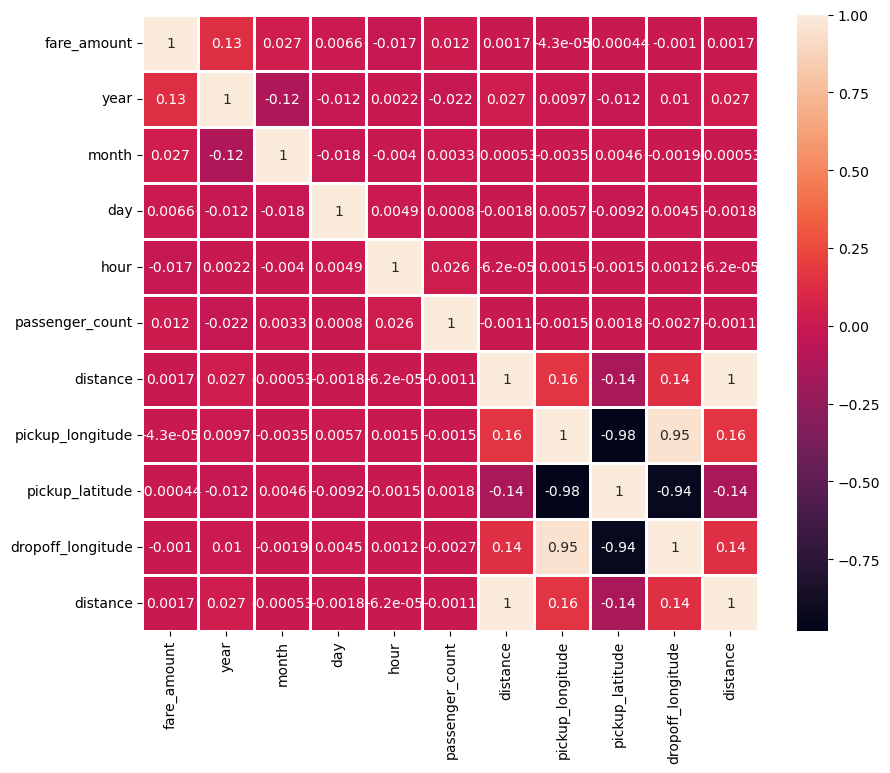

In [124]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, square=True, annot=True, linewidths=1)

### Зависимость есть только у долготы и широты, что достаточно логично, у остальных признаков особой кориляции не выявленно

### 3. Обучение классификатора

### Формирование дата-сета для обучения моделей

In [121]:
# список имён признаков, которые будут использоваться для построения модели
X = df[['year','month','day','hour','passenger_count', "distance", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "distance"]]
# выделение целевой переменной в отдельный вектор
y = df['fare_amount']

In [123]:
X

,year,month,day,hour,passenger_count,distance,pickup_longitude,pickup_latitude,dropoff_longitude,distance
0,2015,5,7,19,1,1.68,-73.999817,40.738354,-73.999512,1.68
1,2009,7,17,20,1,2.45,-73.994355,40.728225,-73.994710,2.45
2,2009,8,24,21,1,5.04,-74.005043,40.740770,-73.962565,5.04
3,2009,6,26,8,3,1.66,-73.976124,40.790844,-73.965316,1.66
4,2014,8,28,17,1,4.48,-73.925023,40.744085,-73.973082,4.48
...,...,...,...,...,...,...,...,...,...,...
199995,2012,10,28,10,1,0.11,-73.987042,40.739367,-73.986525,0.11
199996,2014,3,14,1,1,1.88,-73.984722,40.736837,-74.006672,1.88
199997,2009,6,29,0,2,12.87,-73.986017,40.756487,-73.858957,12.87
199998,2015,5,20,14,1,3.54,-73.997124,40.725452,-73.983215,3.54


In [125]:
y

0          7.5
1          7.7
2         12.9
3          5.3
4         16.0
          ... 
199995     3.0
199996     7.5
199997     8.5
199998    14.5
199999    14.1
Name: fare_amount, Length: 199252, dtype: float64

In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [149]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [151]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [153]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 3.25398850032371
MSE: 18.2129499887864
RMSE: 4.267663293745935
R2 Square 0.01701778488124539
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.2605893049561865
MSE: 18.360973799194806
RMSE: 4.284970688253866
R2 Square 0.018958963702962794
__________________________________


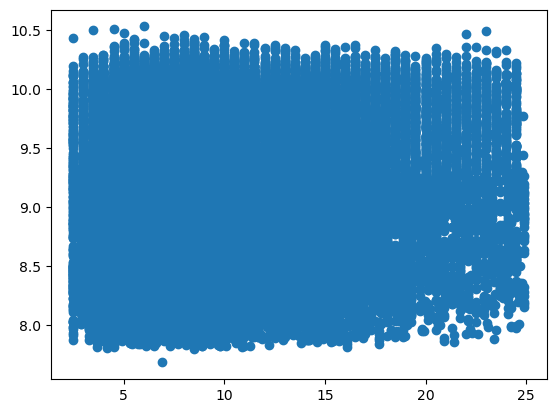

In [155]:
plt.scatter(Y_test,y_pred)

# Ridge Regression

In [65]:
from sklearn.linear_model import Ridge

In [69]:
model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, Y_train)
predRidge = model.predict(X_test)

In [71]:
print('mean_Absolute-Error',metrics.mean_absolute_error(Y_test,predRidge))

mean_Absolute-Error 3.2539193339482257


In [73]:
print('mean-squared-error',metrics.mean_squared_error(Y_test,predRidge))

mean-squared-error 18.212672133896437


In [75]:
print('r2score',metrics.r2_score(Y_test,predRidge))

r2score 0.017032781156718912


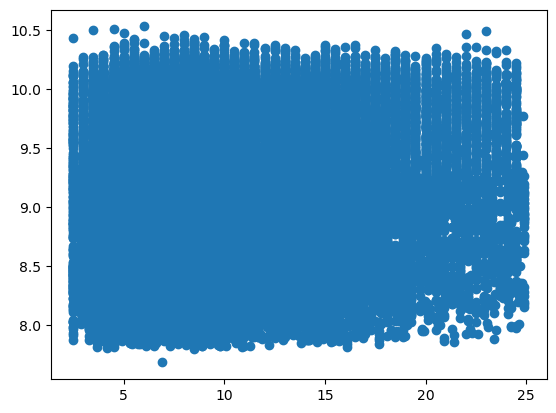

In [77]:
plt.scatter(Y_test,predRidge)

# LASSO Regression

In [79]:
from sklearn.linear_model import Lasso

In [81]:
model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, Y_train)

predLasso = model.predict(X_test)

In [83]:
print('mean_Absolute-Error',metrics.mean_absolute_error(Y_test,predRidge))

mean_Absolute-Error 3.2539193339482257


In [85]:
print('mean-squared-error',metrics.mean_squared_error(Y_test,predRidge))

mean-squared-error 18.212672133896437


In [87]:
print('r2score',metrics.r2_score(Y_test,predRidge))

r2score 0.017032781156718912


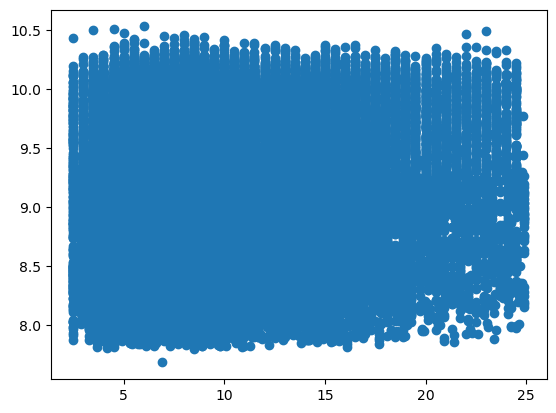

In [89]:
plt.scatter(Y_test,predRidge)

In [91]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,1.68
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,2.45
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,5.04
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,1.66
4,16.0,-73.925023,40.744085,-73.973082,40.761247,1,2014,8,28,17,4.48


# Polynomial Regression

In [94]:
from sklearn.preprocessing import PolynomialFeatures

In [96]:
poly_reg = PolynomialFeatures(degree=2)
poly_reg.fit(X_train, Y_train)
predPolynomialFeatures = model.predict(X_test)

In [98]:
print('mean_Absolute-Error', metrics.mean_absolute_error(Y_test,predPolynomialFeatures))

mean_Absolute-Error 3.2533935249937476


In [100]:
print('mean-squared-error', metrics.mean_squared_error(Y_test,predPolynomialFeatures))

mean-squared-error 18.22356092500788


In [102]:
print('r2score', metrics.r2_score(Y_test,predPolynomialFeatures))

r2score 0.01644509558061602


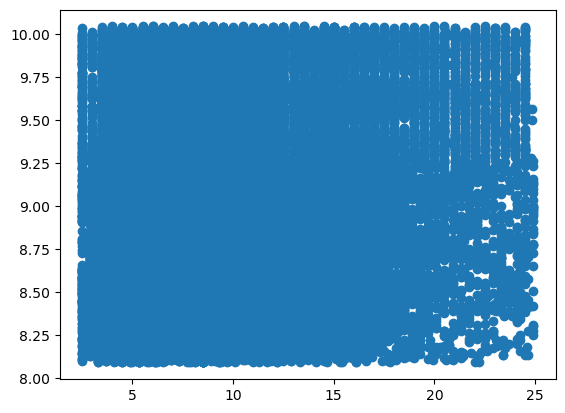

In [104]:
plt.scatter(Y_test,predPolynomialFeatures)

### Общий вывод: т.к данные не коррилирируют между собой, 